In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv('./data/train.csv').drop(columns = ['Id'])
df_num = df.select_dtypes(include = ['float64', 'int64'])


In [3]:
df_test = pd.read_csv('./data/test.csv').drop(columns = ['Id'])
df_test['SalePrice'] = pd.read_csv('./data/sample_submission.csv')['SalePrice']


In [4]:
def get_numerical(df : pd.DataFrame, columns : list):
    
    for column in columns:
        id = df[column].unique()
        df[column].replace(id, np.arange(len(id)), inplace = True)
    return df   

In [5]:
df_num = get_numerical(df, list(df.select_dtypes(exclude = ['float64', 'int64']).columns))
df_num_test = get_numerical(df_test, list(df_test.select_dtypes(exclude = ['float64', 'int64']).columns))

WORD EMBEDDINGS

/home/andrea/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/andrea/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/andrea/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/andrea/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN 

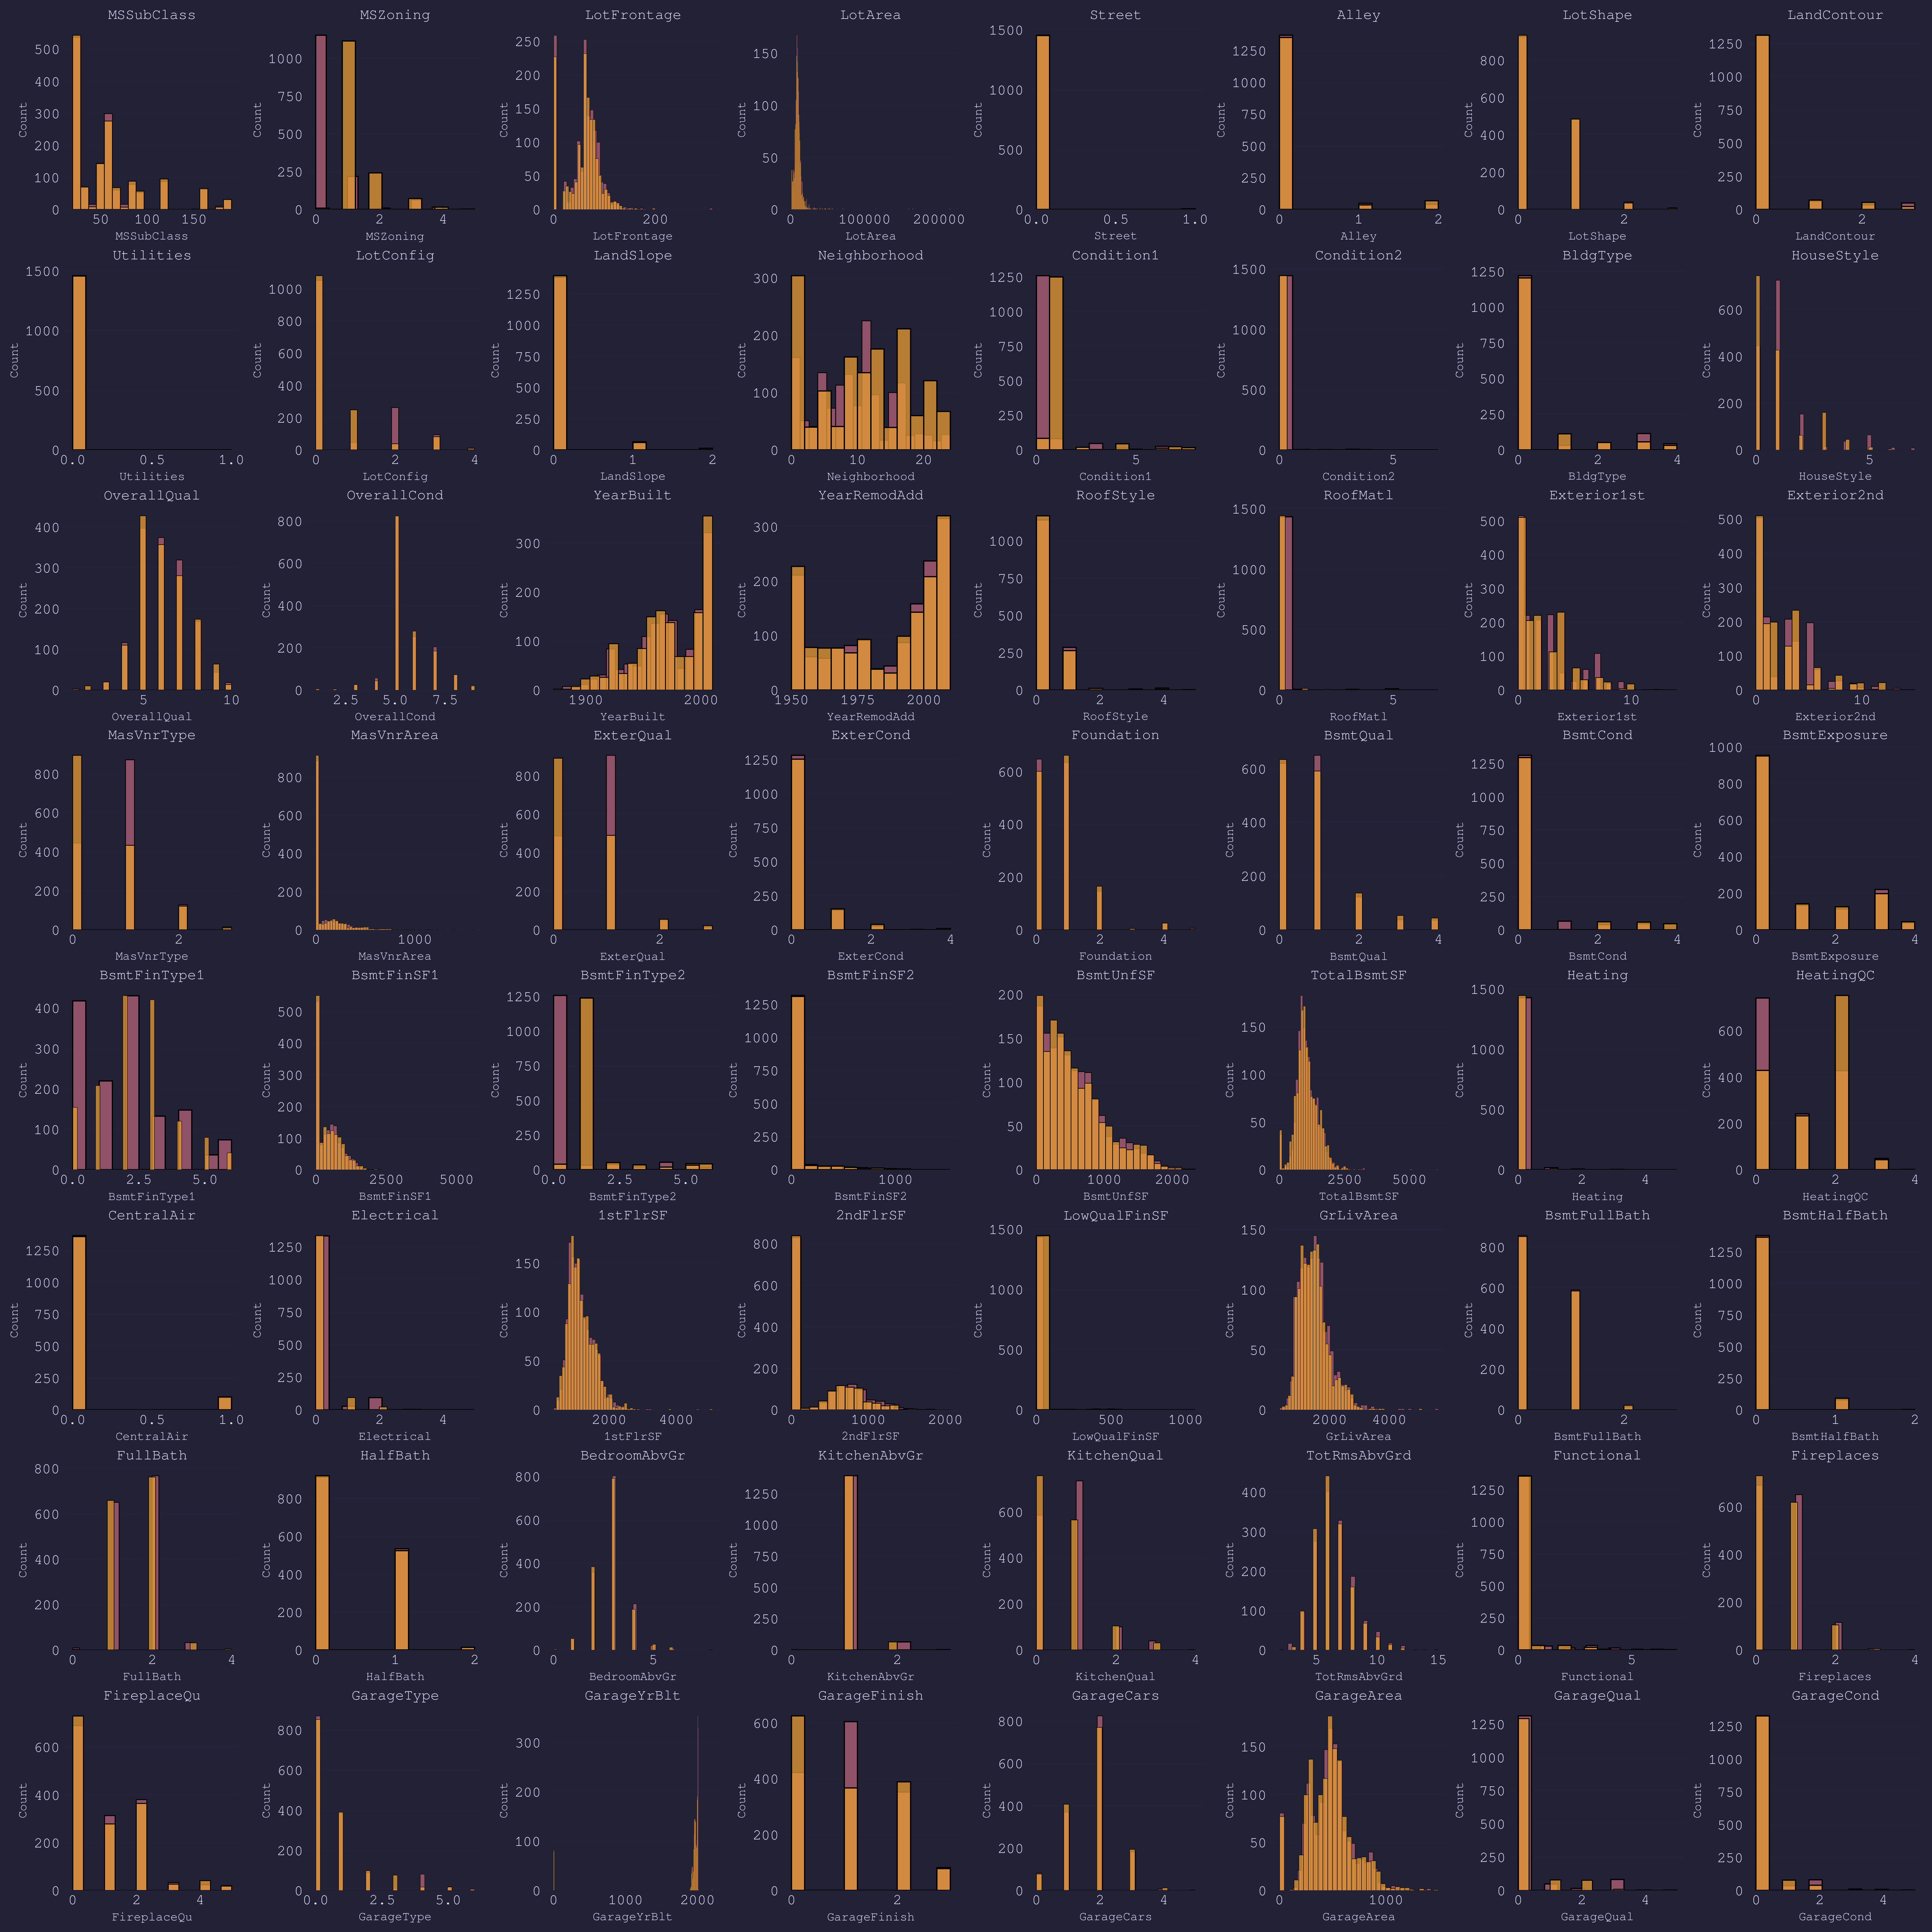

In [26]:
n = int(np.sqrt(len(df_num.columns)))
fig,ax = plt.subplots(n,n,figsize=(20,20))
ax = ax.flatten()
for a,b in zip(df_num_test.columns,ax):
    sns.histplot(df_num[a],ax=b)
    sns.histplot(df_num_test[a],ax=b)
    b.set_title(a)


In [ ]:
df_num.corr()['SalePrice'].sort_values(ascending=False)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
                  ...   
GarageType     -0.255560
ExterQual      -0.265015
BsmtFinType1   -0.370971
HeatingQC      -0.427649
Foundation     -0.429678
Name: SalePrice, Length: 80, dtype: float64

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split


In [9]:
df_num.fillna(0, inplace=True)
df_num.fillna(0, inplace = True)

df_num_test.fillna(0, inplace=True)
df_num_test.fillna(0, inplace = True)


In [10]:
scaler = RobustScaler()
df_num_scaled = scaler.fit_transform(df_num.drop(columns=['SalePrice']))
df_num_test_scaled = scaler.transform(df_num_test.drop(columns=['SalePrice']))

In [11]:
from sklearn.ensemble import StackingRegressor


estimators = [('rf', RandomForestRegressor(n_estimators=300, max_depth = 20)), ('gb', GradientBoostingRegressor(n_estimators=300, max_depth = 20)), ('ada', AdaBoostRegressor(n_estimators=200))]
clf = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor(n_estimators=200, max_depth = 10, criterion='absolute_error'),passthrough = True )

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_num_scaled, df_num['SalePrice'], test_size=0.2, random_state=42)

In [13]:
clf.fit(X_train, y_train)

StackingRegressor(estimators=[('rf',
                               RandomForestRegressor(max_depth=20,
                                                     n_estimators=300)),
                              ('gb',
                               GradientBoostingRegressor(max_depth=20,
                                                         n_estimators=300)),
                              ('ada', AdaBoostRegressor(n_estimators=200))],
                  final_estimator=RandomForestRegressor(criterion='absolute_error',
                                                        max_depth=10,
                                                        n_estimators=200),
                  passthrough=True)

In [14]:
clf.score(X_test, y_test)

0.8783199807757799

In [15]:
clf.score(df_num_test_scaled, df_num_test['SalePrice'])

-16.980838434775688

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  2.,  0.,  2.,  2.,  4.,
         4.,  7., 14., 26., 49., 65., 40., 28., 16., 10.,  7.,  5.,  0.,
         1.,  3.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-241373.91  , -233750.2323, -226126.5546, -218502.8769,
        -210879.1992, -203255.5215, -195631.8438, -188008.1661,
        -180384.4884, -172760.8107, -165137.133 , -157513.4553,
        -149889.7776, -142266.0999, -134642.4222, -127018.7445,
        -119395.0668, -111771.3891, -104147.7114,  -96524.0337,
         -88900.356 ,  -81276.6783,  -73653.0006,  -66029.3229,
         -58405.6452,  -50781.9675,  -43158.2898,  -35534.6121,
         -27910.9344,  -20287.2567,  -12663.579 ,   -5039.9013,
           2583.7764,   10207.4541,   17831.1318,   25454.8095,
          33078.4872,   40702.1649,   48325.8426,   55949.5203,
          63573.198 ,   71196.8757,   78820.5534,   86444.2311,
          94

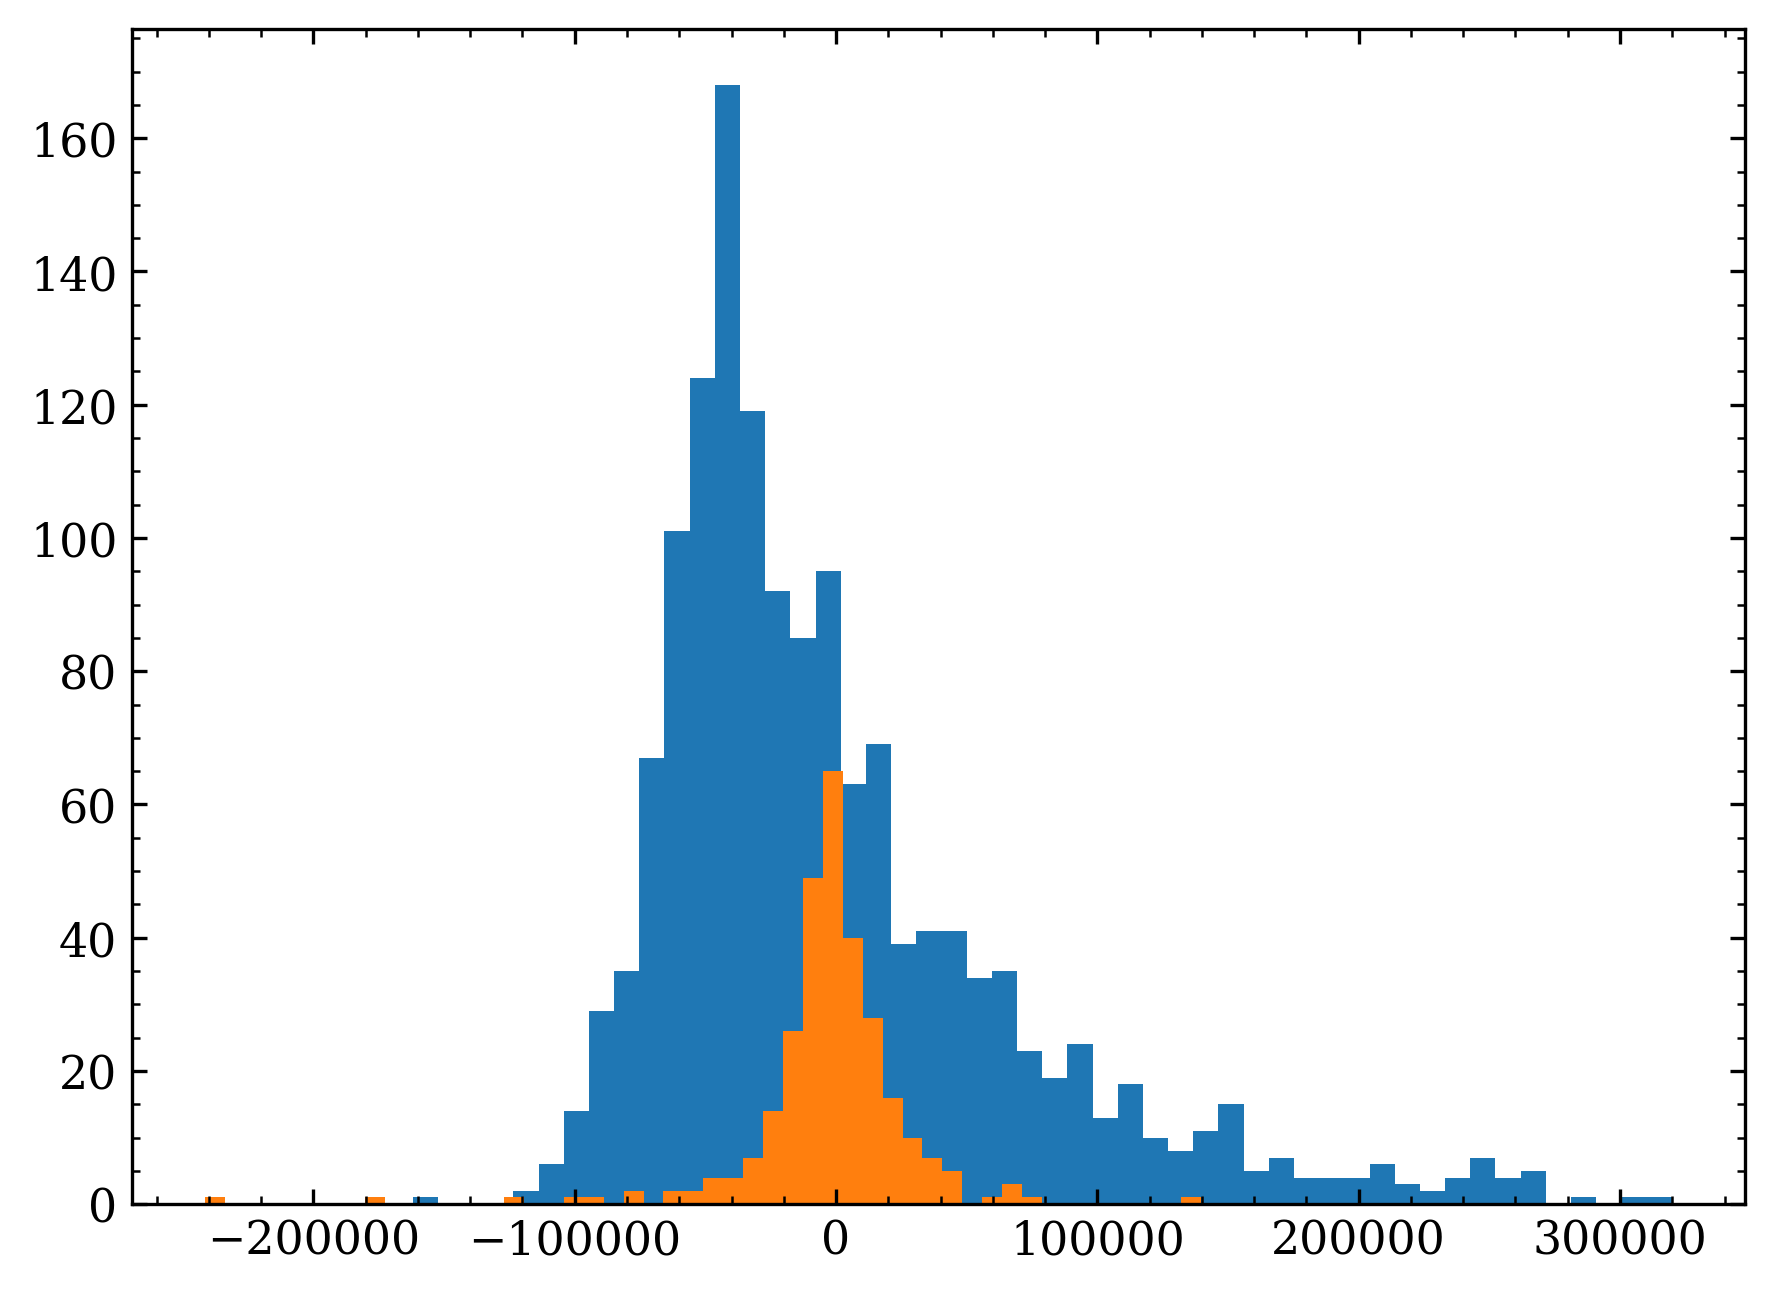

In [16]:
fig, ax = plt.subplots()
ax.hist(clf.predict(df_num_test_scaled) - df_num_test['SalePrice'], bins = 50)
ax.hist(clf.predict(X_test) - y_test, bins = 50)

In [23]:
plt.style.use('rose-pine')

(135751.318892816, 281643.976116786)

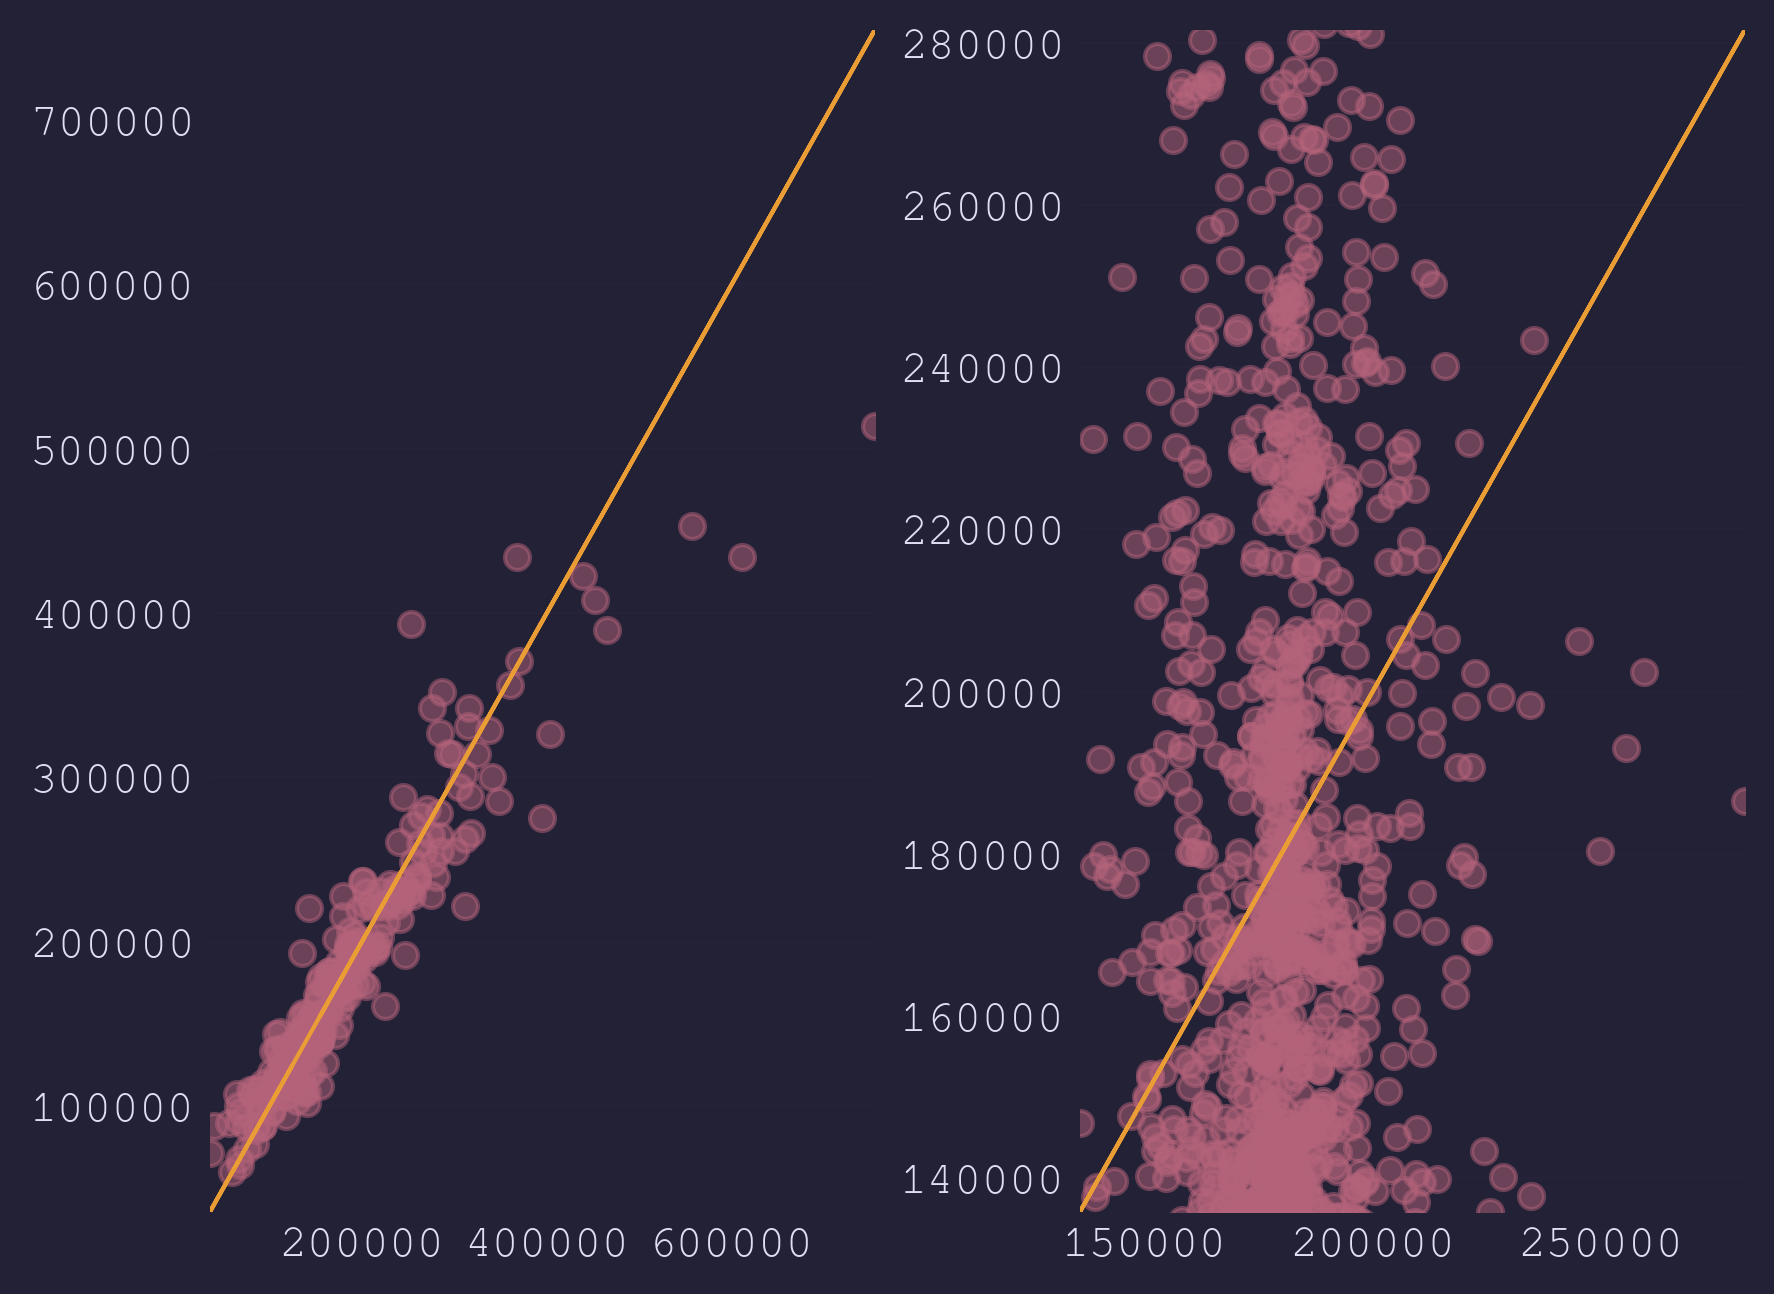

In [25]:
fig, ax = plt.subplots(1,2)
ax[0].plot(y_test, clf.predict(X_test), 'o', lw = 0, alpha = .5)
ax[0].plot(y_test, y_test, lw=1)
ax[0].set_xlim(y_test.min(), y_test.max())
ax[0].set_ylim(y_test.min(), y_test.max())

ax[1].plot(df_num_test['SalePrice'], clf.predict(df_num_test_scaled), 'o', lw = 0, alpha = .5)
ax[1].plot(df_num_test['SalePrice'], df_num_test['SalePrice'], lw=1)
ax[1].set_xlim(df_num_test['SalePrice'].min(), df_num_test['SalePrice'].max())
ax[1].set_ylim(df_num_test['SalePrice'].min(), df_num_test['SalePrice'].max())
